/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:31:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


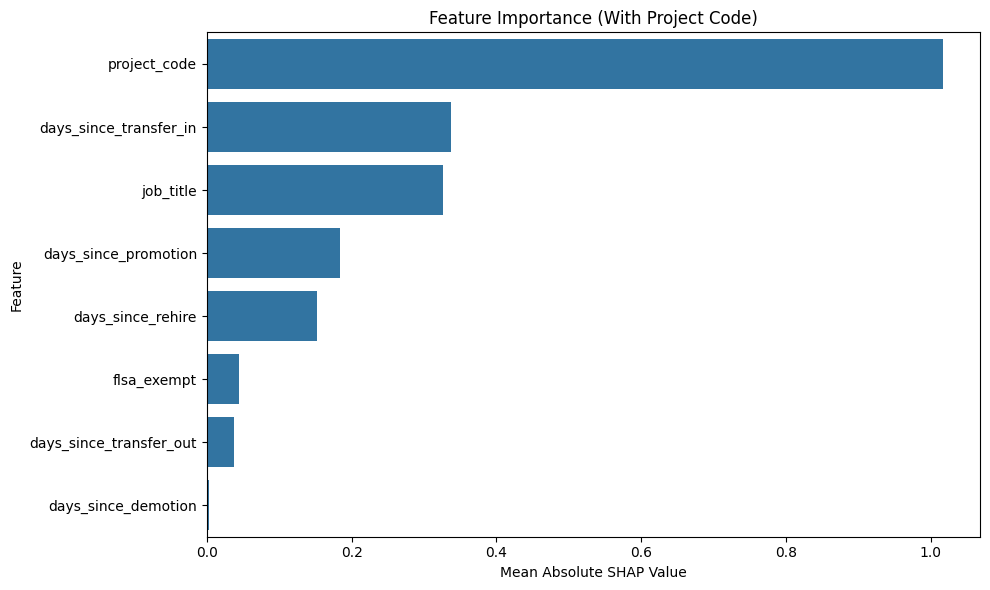

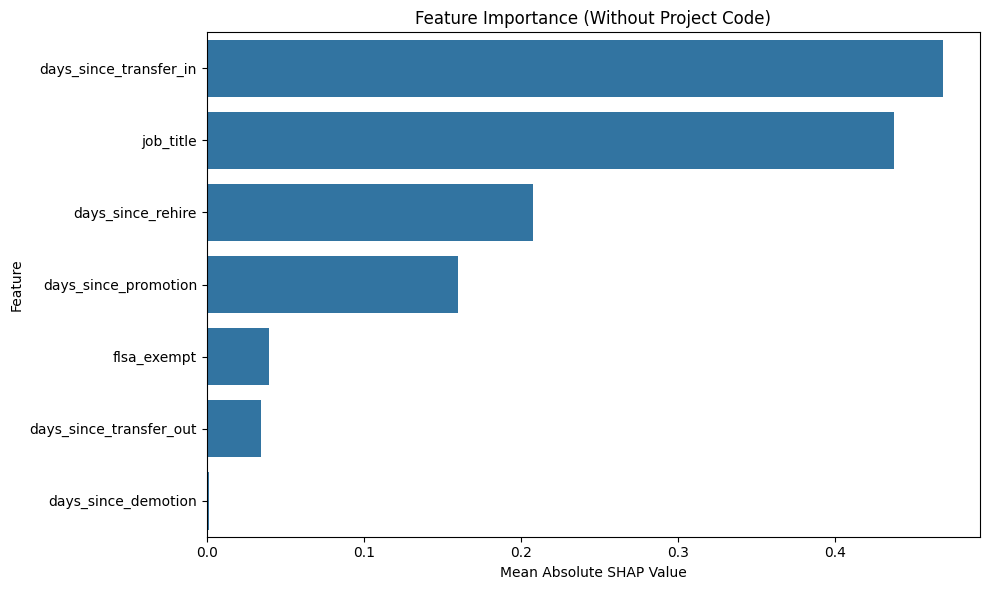

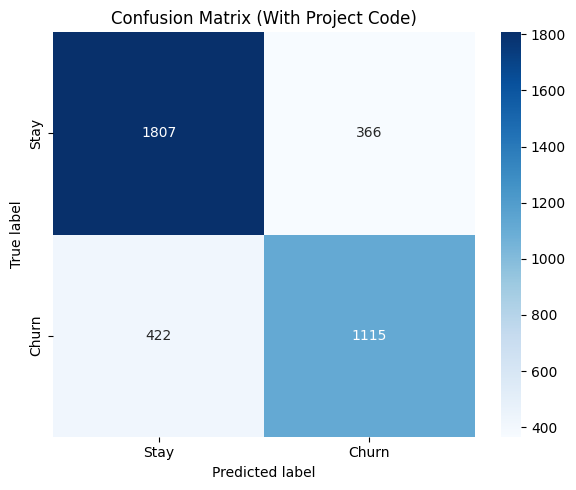

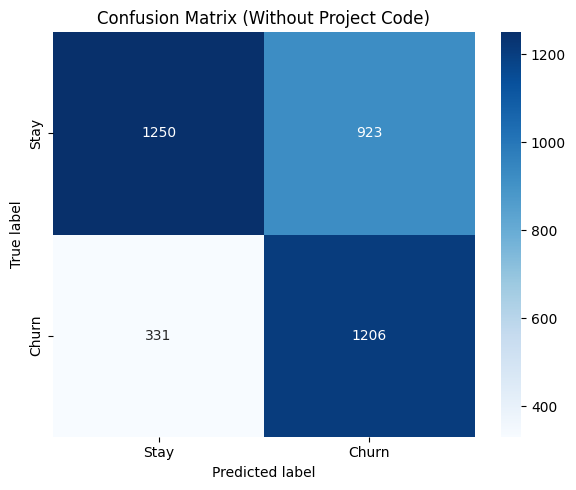

In [ ]:
# ----------------------------------------
# 0. Imports
# ----------------------------------------
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import threading
from threading import Event
import numpy as np

# ----------------------------------------
# 1. Load and Prepare Data
# ----------------------------------------

def load_data():
    df = pd.read_csv("merged.csv")

    # Encode categoricals
    categorical_cols = ['job_title', 'project_code', 'flsa_exempt']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Create churn target
    df['churn'] = ((df['left'] == 1) | (df['fired'] == 1)).astype(int)

    return df

df = load_data()

# ----------------------------------------
# 2. Define Features
# ----------------------------------------

features_with_project = [
    'days_since_promotion', 'days_since_demotion',
    'days_since_transfer_in', 'days_since_transfer_out',
    'days_since_rehire', 'job_title', 'project_code', 'flsa_exempt'
]

features_without_project = [
    'days_since_promotion', 'days_since_demotion',
    'days_since_transfer_in', 'days_since_transfer_out',
    'days_since_rehire', 'job_title', 'flsa_exempt'
]

y = df['churn']

# ----------------------------------------
# 3. Train Both Models
# ----------------------------------------

X_with_project = df[features_with_project].apply(pd.to_numeric, errors='coerce').fillna(0)
X_without_project = df[features_without_project].apply(pd.to_numeric, errors='coerce').fillna(0)

X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with_project, y, test_size=0.3, random_state=42, stratify=y
)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(
    X_without_project, y, test_size=0.3, random_state=42, stratify=y
)

xgb_with_project = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_without_project = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_with_project.fit(X_train_with, y_train_with)
xgb_without_project.fit(X_train_without, y_train_without)

# ----------------------------------------
# 4. Predictions and Feature Importance
# ----------------------------------------

df['xgb_churn_with_project'] = xgb_with_project.predict_proba(X_with_project)[:, 1]
df['xgb_churn_without_project'] = xgb_without_project.predict_proba(X_without_project)[:, 1]

df.to_csv('xgb_predictions_combined.csv', index=False)

# --- Feature Importance WITH project_code ---
booster_with = xgb_with_project.get_booster()
fscore_with = booster_with.get_score(importance_type='weight')
fscore_df_with = pd.DataFrame({
    'Feature': list(fscore_with.keys()),
    'FScoreImportance': list(fscore_with.values())
})

explainer_with = shap.TreeExplainer(xgb_with_project)
shap_values_with = explainer_with.shap_values(X_with_project)

shap_df_with = pd.DataFrame({
    'Feature': X_with_project.columns,
    'MeanAbsSHAP': np.abs(shap_values_with).mean(axis=0),
    'SHAPDirection': shap_values_with.mean(axis=0)
})

feature_importance_with = pd.merge(
    fscore_df_with, shap_df_with, on='Feature', how='outer'
).sort_values(by='MeanAbsSHAP', ascending=False)

feature_importance_with.to_csv('xgb_feature_importances_with_project.csv', index=False)

# --- Feature Importance WITHOUT project_code ---
booster_without = xgb_without_project.get_booster()
fscore_without = booster_without.get_score(importance_type='weight')
fscore_df_without = pd.DataFrame({
    'Feature': list(fscore_without.keys()),
    'FScoreImportance': list(fscore_without.values())
})

explainer_without = shap.TreeExplainer(xgb_without_project)
shap_values_without = explainer_without.shap_values(X_without_project)

shap_df_without = pd.DataFrame({
    'Feature': X_without_project.columns,
    'MeanAbsSHAP': np.abs(shap_values_without).mean(axis=0),
    'SHAPDirection': shap_values_without.mean(axis=0)
})

feature_importance_without = pd.merge(
    fscore_df_without, shap_df_without, on='Feature', how='outer'
).sort_values(by='MeanAbsSHAP', ascending=False)

feature_importance_without.to_csv('xgb_feature_importances_without_project.csv', index=False)

# ----------------------------------------
# 5. Plotting
# ----------------------------------------

# --- Feature Importance Bar Plot ---
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=importance_df,
        y='Feature', x='MeanAbsSHAP',
        orient='h'
    )
    plt.title(title)
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance_with, 'Feature Importance (With Project Code)')
plot_feature_importance(feature_importance_without, 'Feature Importance (Without Project Code)')

# --- Confusion Matrices ---
def plot_conf_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay','Churn'], yticklabels=['Stay','Churn'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(xgb_with_project, X_test_with, y_test_with, 'Confusion Matrix (With Project Code)')
plot_conf_matrix(xgb_without_project, X_test_without, y_test_without, 'Confusion Matrix (Without Project Code)')

# ----------------------------------------
# 6. Auto-Refresh Loop
# ----------------------------------------

stop_event = Event()

def refresh_loop(interval_seconds=1800):
    while not stop_event.is_set():
        df = load_data()
        X_with_project = df[features_with_project].apply(pd.to_numeric, errors='coerce').fillna(0)
        X_without_project = df[features_without_project].apply(pd.to_numeric, errors='coerce').fillna(0)

        df['xgb_churn_with_project'] = xgb_with_project.predict_proba(X_with_project)[:, 1]
        df['xgb_churn_without_project'] = xgb_without_project.predict_proba(X_without_project)[:, 1]

        df.to_csv('xgb_predictions_combined.csv', index=False)

        shap_values_with = explainer_with.shap_values(X_with_project)
        shap_df_with = pd.DataFrame({
            'Feature': X_with_project.columns,
            'MeanAbsSHAP': np.abs(shap_values_with).mean(axis=0),
            'SHAPDirection': shap_values_with.mean(axis=0)
        })
        feature_importance_with = pd.merge(
            fscore_df_with, shap_df_with, on='Feature', how='outer'
        ).sort_values(by='MeanAbsSHAP', ascending=False)
        feature_importance_with.to_csv('xgb_feature_importances_with_project.csv', index=False)

        shap_values_without = explainer_without.shap_values(X_without_project)
        shap_df_without = pd.DataFrame({
            'Feature': X_without_project.columns,
            'MeanAbsSHAP': np.abs(shap_values_without).mean(axis=0),
            'SHAPDirection': shap_values_without.mean(axis=0)
        })
        feature_importance_without = pd.merge(
            fscore_df_without, shap_df_without, on='Feature', how='outer'
        ).sort_values(by='MeanAbsSHAP', ascending=False)
        feature_importance_without.to_csv('xgb_feature_importances_without_project.csv', index=False)

        print

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming you have these
# y_true: true binary labels (0 for Stay, 1 for Churn)
# y_pred_proba: predicted probabilities for the positive class (Churn)

# Calculate AUC-ROC
auc = roc_auc_score(y_true, y_pred_proba)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (With Project Code)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


NameError: name 'y_true' is not defined